# Imports

## Grant access to your google drive (if using Google Collab), import python packages and set paths

### Tests if mounting google drive is possible to determine if the code is run on google collab (GOOGLE=TRUE)

In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    GOOGLE = True
    baseFolder = '/content/drive/My Drive/DeeProtein2/'
except:
    GOOGLE = False
    baseFolder = '~/DeepProtein2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
def FldToShell(txt):
    #converts space to '\ ' to use filepath in shell commands
    return txt.replace(' ','\ ')
!ls {FldToShell(baseFolder)}

AssignLabels_SplitTestValidSet.ipynb  Training_Analysis.ipynb
GenerateDataset.ipynb


In [0]:
import re
import os
if GOOGLE:
    !pip install goatools
from goatools.obo_parser import GODag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Iterable

     |████████████████████████████████| 15.1MB 3.6MB/s 
     |████████████████████████████████| 163kB 38.8MB/s 
     |████████████████████████████████| 143kB 40.0MB/s 
     |████████████████████████████████| 215kB 43.8MB/s 
  Created wheel for goatools: filename=goatools-0.9.9-cp36-none-any.whl size=15757842 sha256=9fab30ebe00b8766eb74ce16cb1e074f2b459f495111e3c344e9d909d0c6bb1a
  Stored in directory: /root/.cache/pip/wheels/f1/a4/fe/f6167cf69ce3b53e45326b10e735cd1007780f2f4522f85a34
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=111bf34c6e73e8130aa5cae2687f3e3f9c8d298c48c8505a80ba4c04b98792f8
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built goatools wget
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR

In [0]:
datasetFolder = baseFolder + 'CleaningDataset/'
datasetFile = datasetFolder + 'uniprot_sprot.dat'
godagFile = baseFolder + 'go-basic.obo'
uniprot_csv_path = datasetFolder + 'uniprot_prefiltered.csv'
#create folders
if not os.path.exists(datasetFolder):
    drive.mount('/content/drive/', force_remount=True)
    os.mkdir(datasetFolder)
#download GO terms hierarchy from geneontology website
if not os.path.isfile(godagFile):
    curDir = os.getcwd()
    os.chdir(baseFolder)
    !wget http://geneontology.org/ontology/go-basic.obo
    os.chdir(curDir)


In [0]:
GODagTerms = GODag(godagFile, optional_attrs=['relationship'])

/content/drive/My Drive/DeeProtein2/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms; optional_attrs(relationship)


# Convert raw data to pandas dataframe with sequences and GO terms

## Downloading raw dataset file SwissProt (from uniprot)

In [0]:
def getUniprot():
    if os.path.isfile(datasetFile):
        print('datasetFile exists!')
        return
    if not os.path.exists(datasetFolder):
        raise Exception('couldnt find datasetFolder',datasetFolder)
    curDir = os.getcwd()
    os.chdir(datasetFolder)
    !wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.dat.gz
    !gzip -d uniprot_sprot.dat.gz
    os.chdir(curDir)
getUniprot()

--2019-10-21 14:10:26--  ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.dat.gz
           => ‘uniprot_sprot.dat.gz’
Resolving ftp.uniprot.org (ftp.uniprot.org)... 141.161.180.197
Connecting to ftp.uniprot.org (ftp.uniprot.org)|141.161.180.197|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/uniprot/current_release/knowledgebase/complete ... done.
==> SIZE uniprot_sprot.dat.gz ... 580374956
==> PASV ... done.    ==> RETR uniprot_sprot.dat.gz ... done.
Length: 580374956 (553M) (unauthoritative)

uniprot_sprot.dat.g 100%[===================>] 553.49M  1.46MB/s    in 6m 1s   

2019-10-21 14:16:28 (1.53 MB/s) - ‘uniprot_sprot.dat.gz’ saved [580374956]



**Contents datafile**

In [0]:
!tail -20 {FldToShell(datasetFile)}

KW   Complete proteome; Host cell membrane; Host cytoplasm; Host membrane;
KW   Host-virus interaction; Lipoprotein; Membrane; Metal-binding;
KW   Myristate; Reference proteome; Viral budding;
KW   Viral budding via the host ESCRT complexes;
KW   Viral release from host cell; Virion; Zinc; Zinc-finger.
FT   INIT_MET      1      1       Removed; by host. {ECO:0000255|HAMAP-
FT                                Rule:MF_04087}.
FT   CHAIN         2     95       RING finger protein Z.
FT                                {ECO:0000255|HAMAP-Rule:MF_04087}.
FT                                /FTId=PRO_0000361042.
FT   ZN_FING      38     74       RING-type; atypical. {ECO:0000255|HAMAP-
FT                                Rule:MF_04087}.
FT   MOTIF        88     91       PTAP/PSAP motif. {ECO:0000255|HAMAP-
FT                                Rule:MF_04087}.
FT   LIPID         2      2       N-myristoyl glycine; by host.
FT                                {ECO:0000255|HAMAP-Rule:MF_04087}.
SQ   SEQUENCE

**Convert uniprot file to csv**

In [0]:
#credit to Team Heildeberg 2y_test017 for this function
def uniprot_to_csv(GODagTerms, uniprot_csv_path):
    """Convert the raw uniprot download into a csv file.

    Converts the raw uniprot.txt download (specified in the class_attributes) into a .csv file with the
    following syntax:

    name;rec_name;Pfam;protein_existance;seq;F_GO;P_GO;C_GO;EC;Structure

    The whole dataframe is held in memory
    """
    def _full_annotation(GO_terms):
        """Takes a list of GO_terms and expands them to full annotation.

        Completes the subdag defined by a list of GO-terms by walking up the GOdag.

        Args:
          GO_terms: `list` the GO_terms to expand.
        Returns:
          A fully annotated list of GO terms including all nodes passed on the way to root.
        """
        full_go = set()

        omitted_GOs = []

        for go in GO_terms:
            # determine if a node has parents and retrieve the set of parent-nodes
            try:
                full_go.update(GODagTerms[go].get_all_parents())
                full_go.add(go)
            except KeyError:
                # this means the term might be obsolete as its not in the DAG. store it
                omitted_GOs.append(go)
                pass
        if len(omitted_GOs)>0:
            print('omitted_GOs',omitted_GOs)

        full_go = ','.join(list(full_go))

        return full_go

            
    #do not have to write file again if already exists
    if os.path.isfile(uniprot_csv_path):
        print('Lazy: file with prefiltered sequences from uniprot already exists: %s' %uniprot_csv_path)
        return

    with open(datasetFile, "r") as in_fobj:
        uniprot_dict = {}
        curr_prot_id = ''
        curr_F_GOs = []
        curr_P_GOs = []
        curr_C_GOs = []
        curr_ECs = []
        curr_structure = []
        seq = False
        for line in in_fobj:
            fields = line.strip().split()
            flag = fields[0]
            if flag == 'ID' and len(fields) >= 2:
                curr_prot_id y_test= fields[1]
                uniprot_dict[curr_prot_id] = {}
            elif flag == 'DE' and len(fields) >= 2:
                rec_name = re.search(r'(?<=Full=)(.+?)[;\s]', line)
                ec_nr = re.search(r'(?<=EC=)([0-9.-]*?)[;\s]', line)
                if ec_nr:
                    curr_ECs.append(ec_nr.group(1))
                elif rec_name:
                    uniprot_dict[curr_prot_id]['rec_name'] = rec_name.group(1)
            elif flag == 'DR' and len(fields) >= 2:
                '''
                abfrage fuer GOS und PFAM
                '''
                # ask for GO first:
                dr_fields = [ref.rstrip('.;') for ref in fields[1:]]
                # TODO: should we filter for funcitonalilty here?
                if dr_fields[0] == 'GO' and dr_fields[2].startswith('F'):
                    curr_F_GOs.append(dr_fields[1])
                    # try:
                    #     uniprot_dict[curr_prot_id]['GO'].append(dr_fields[1])
                    # except KeyError:
                    #     uniprot_dict[curr_prot_id]['GO'] = [dr_fields[1]]
                elif dr_fields[0] == 'GO' and dr_fields[2].startswith('P'):
                    curr_P_GOs.append(dr_fields[1])
                elif dr_fields[0] == 'GO' and dr_fields[2].startswith('C'):
                    curr_C_GOs.append(dr_fields[1])

                elif dr_fields[0] == 'Pfam':
                    uniprot_dict[curr_prot_id]['Pfam'] = dr_fields[2:]
                else:
                    pass
            elif flag == 'CC' and len(fields) >= 2:
                '''
                may content sequence caution warning
                '''
                pass

            elif flag == 'PE' and len(fields) >= 2:
                protein_existance = fields[1]
                uniprot_dict[curr_prot_id]['protein_existance'] = protein_existance

            elif flag == 'FT' and len(fields) >= 2:
                """
                the annotated features. (http://www.uniprot.org/help/sequence_annotation)
                Those are anotations like catalytic site, binding sites and secondary structure
                """
                ft_fields = fields[1:]
                if ft_fields[0] == 'HELIX':
                    curr_structure.append(('HELIX', fields[2], fields[3]))
                if ft_fields[0] == 'STRAND':
                    curr_structure.append(('STRAND', fields[2], fields[3]))
                if ft_fields[0] == 'SHEET':
                    curr_structure.append(('SHEET', fields[2], fields[3]))
                if ft_fields[0] == 'TURN':
                    curr_structure.append(('TURN', fields[2], fields[3]))
            elif flag == 'SQ' and len(fields) >= 2:
                seq = True
                uniprot_dict[curr_prot_id]['seq'] = ''
            elif seq == True:
                if flag == '//':
                    uniprot_dict[curr_prot_id]['F_GO'] = _full_annotation(curr_F_GOs)
                    uniprot_dict[curr_prot_id]['P_GO'] = _full_annotation(curr_P_GOs)
                    uniprot_dict[curr_prot_id]['C_GO'] = _full_annotation(curr_C_GOs)
                    uniprot_dict[curr_prot_id]['EC'] = curr_ECs
                    uniprot_dict[curr_prot_id]['Structure'] = curr_structure
                    curr_prot_id = ''
                    seq = False
                    # set collectors to []
                    curr_F_GOs = []
                    curr_C_GOs = []
                    curr_P_GOs = []
                    curr_ECs = []
                    curr_structure = []
                else:
                    uniprot_dict[curr_prot_id]['seq'] += ''.join(fields)
            else:
                pass
        uniprot_df = pd.DataFrame.from_dict(uniprot_dict, orient='index')
        del uniprot_dict
        uniprot_df.to_csv(uniprot_csv_path, sep=';', na_rep='', header=True, index=True,
                          line_terminator='\n')

In [0]:
uniprot_to_csv(GODagTerms, uniprot_csv_path)

omitted_GOs ['GO:0097235', 'GO:0061424']
omitted_GOs ['GO:1900474']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0075206']
omitted_GOs ['GO:0035959']
omitted_GOs ['GO:1900375', 'GO:1900478', 'GO:0061432']
omitted_GOs ['GO:2000531']
omitted_GOs ['GO:1900471', 'GO:1900375']
omitted_GOs ['GO:1904741']
omitted_GOs ['GO:0035957']
omitted_GOs ['GO:1900402']
omitted_GOs ['GO:1900392']
omitted_GOs ['GO:0110144']
omitted_GOs ['GO:0110144']
omitted_GOs ['GO:0110144']
omitted_GOs ['GO:0110144']
omitted_GOs ['GO:0110144']
omitted_GOs ['GO:0110144']
omitted_GOs ['GO:0110144']
omitted_GOs ['GO:0110144']
omitted_GOs ['GO:0036083']
omitted_GOs ['GO:1900402']
omitted_GOs ['GO:1900402']
omitted_GOs ['GO:0036095', 'GO:0035957']
omitted_GOs ['GO:0061434']
omitted_GOs ['GO:0061434']
omitted_GOs 

In [0]:
#import data as pandas dataframe
df = pd.read_csv(uniprot_csv_path, sep=';')

In [0]:
#GO terms of sequences are sorted by molecular function (F), biological process (P), cellular component (C)
print('shape dataframe', df.shape)
print('total number of sequences %g, unique sequences: %g (fraction: %g), duplicate sequences %g (fraction: %g)' %(df.shape[0], np.size(np.unique(df['seq'].values)), np.size(np.unique(df['seq'].values))/df.shape[0], df.shape[0]-np.size(np.unique(df['seq'].values)), (df.shape[0]-np.size(np.unique(df['seq'].values)))/df.shape[0]))
df.head()

shape dataframe (561176, 10)
total number of sequences 561176, unique sequences: 473271 (fraction: 0.843356), duplicate sequences 87905 (fraction: 0.156644)


,Unnamed: 0,rec_name,Pfam,protein_existance,seq,F_GO,P_GO,C_GO,EC,Structure
0,001R_FRG3G,Putative,"['Pox_VLTF3', '1']",4:,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...,NaN,"GO:0065007,GO:0050789,GO:0008150,GO:0043903,GO...",NaN,[],[]
1,002L_FRG3G,Uncharacterized,"['Pox_G9-A16', '1']",4:,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...,NaN,NaN,"GO:0016021,GO:0110165,GO:0031224,GO:0033643,GO...",[],[]
2,002R_IIV3,Uncharacterized,NaN,4:,MASNTVSAQGGSNRPVRDFSNIQDVAQFLLFDPIWNEQPGSIVPWK...,NaN,NaN,NaN,[],[]
3,003L_IIV3,Uncharacterized,NaN,4:,MYQAINPCPQSWYGSPQLEREIVCKMSGAPHYPNYYPVHPNALGGA...,NaN,NaN,NaN,[],[]
4,003R_FRG3G,Uncharacterized,NaN,3:,MARPLLGKTSSVRRRLESLSACSIFFFLRKFCQKMASLVFLNSPVY...,NaN,NaN,NaN,[],[]


In [0]:
#summary of columns with NaN values
df.isnull().sum() 

Unnamed: 0                0
rec_name                  0
Pfam                  39212
protein_existance         0
seq                       0
F_GO                  87946
P_GO                 117613
C_GO                 148054
EC                        0
Structure                 0
dtype: int64

# Clean dataset

## Remove unconfirmed proteins ##

In [0]:
#protein existance indicates the degree of certainty of the protein's existence (https://www.uniprot.org/help/protein_existence)
#1. Experimental evidence at protein level, 2. Experimental evidence at transcript level, 3. Protein inferred from homology, 4. Protein predicted, 5. Protein uncertain
df['protein_existance'].value_counts()

3:    386908
1:    101731
2:     57295
4:     13420
5:      1822
Name: protein_existance, dtype: int64

In [0]:
#remove all proteins with uncertain existance
df = df.loc[df['protein_existance']!='5:']

## Remove proteins without function##

In [0]:
#determine number of type of terms (F,P,C) that are not NaN -> if NnonNan=0 no GO terms at all found for sequence
def NnonNan(*f):
    return np.sum([x is not np.nan for x in f])
df['NnonNan'] = df.apply(lambda row: NnonNan(row['F_GO'],row['P_GO'],row['C_GO']), axis=1)
df['NnonNan'].value_counts()

3    305490
2    182417
1     46784
0     24663
Name: NnonNan, dtype: int64

In [0]:
#remove all proteins without GO terms
df = df.loc[df['NnonNan']!=0]

## Remove duplicate sequences

In [0]:
#number of duplicated sequences
df.duplicated(subset='seq', keep=False).value_counts()

False    414520
True     120171
dtype: int64

In [0]:
#number of duplicated Pfam IDs
df.duplicated(subset='Pfam', keep=False).value_counts()

True     532216
False      2475
dtype: int64

In [0]:
#convert split GO terms from single strings to list of strings (GO terms)
def split(x):
    if x is not np.nan:
        x = x.split(',')
    return x
df['F_GON'] = df['F_GO'].apply(split)
df['P_GON'] = df['P_GO'].apply(split)
df['C_GON'] = df['C_GO'].apply(split)

In [0]:
#assign duplicated sequences and first duplicate found in dataframe
df['dupl'] = df.duplicated(subset='seq', keep=False)
df['duplFirst'] = df.duplicated(subset='seq', keep='first')

In [0]:
df['dupl'].value_counts()

False    414520
True     120171
Name: dupl, dtype: int64

In [0]:
df['duplFirst'].value_counts()

False    450999
True      83692
Name: duplFirst, dtype: int64

In [0]:
df.head()

,Unnamed: 0,rec_name,Pfam,protein_existance,seq,F_GO,P_GO,C_GO,EC,Structure,NnonNan,F_GON,P_GON,C_GON,dupl,duplFirst
0,001R_FRG3G,Putative,"['Pox_VLTF3', '1']",4:,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...,NaN,"GO:0065007,GO:0050789,GO:0008150,GO:0043903,GO...",NaN,[],[],1,NaN,"[GO:0065007, GO:0050789, GO:0008150, GO:004390...",NaN,False,False
1,002L_FRG3G,Uncharacterized,"['Pox_G9-A16', '1']",4:,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...,NaN,NaN,"GO:0016021,GO:0110165,GO:0031224,GO:0033643,GO...",[],[],1,NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",False,False
5,004R_FRG3G,Uncharacterized,NaN,4:,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...,NaN,NaN,"GO:0016021,GO:0110165,GO:0031224,GO:0033643,GO...",[],[],1,NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",False,False
13,009L_FRG3G,Putative,"['ResIII', '1']",4:,MDTSPYDFLKLYPWLSRGEADKGTLLDAFPGETFEQSLASDVAMRR...,"GO:0032559,GO:0030554,GO:0032555,GO:0042623,GO...",NaN,NaN,['3.6.4.-'],[],1,"[GO:0032559, GO:0030554, GO:0032555, GO:004262...",NaN,NaN,False,False
15,010R_FRG3G,Uncharacterized,NaN,4:,MKMDTDCRHWIVLASVPVLTVLAFKGEGALALAGLLVMAAVAMYRD...,NaN,NaN,"GO:0016021,GO:0110165,GO:0031224,GO:0033643,GO...",[],[],1,NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",False,False


### Visualize distribution of GO terms

In [0]:
cgon = np.ndarray.flatten((df['C_GON'].dropna().apply(lambda x: np.array(x,dtype=str))).values.flatten())
fgon = np.ndarray.flatten((df['F_GON'].dropna().apply(lambda x: np.array(x,dtype=str))).values.flatten())
pgon = np.ndarray.flatten((df['P_GON'].dropna().apply(lambda x: np.array(x,dtype=str))).values.flatten())

In [0]:
flatten = lambda l: [item for sublist in l for item in sublist]
cgon = flatten(cgon)
fgon = flatten(fgon)
pgon = flatten(pgon)

In [0]:
print('total number of C terms %g, F terms %g, P terms %g' %(np.shape(np.unique(np.array(cgon)))[0],np.shape(np.unique(np.array(fgon)))[0],np.shape(np.unique(np.array(pgon)))[0]))

total number of C terms 2860, F terms 7900, P terms 21476


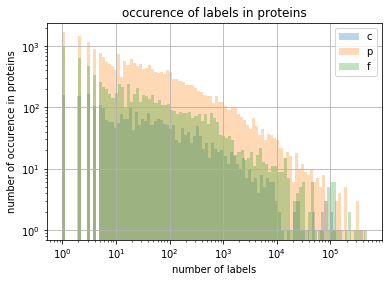

In [0]:
#occurences of labels in dataset proteins split by C,P,F terms  
plt.figure()
ara = cgon
values = pd.DataFrame(ara)[0].value_counts()
bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
pd.DataFrame(ara)[0].value_counts().hist(bins=bins, log=1, alpha=0.3, label='c')

ara = pgon
values = pd.DataFrame(ara)[0].value_counts()
bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
pd.DataFrame(ara)[0].value_counts().hist(bins=bins, log=1, alpha=0.3, label='p')

ara = fgon
values = pd.DataFrame(ara)[0].value_counts()
bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
pd.DataFrame(ara)[0].value_counts().hist(bins=bins, log=1, alpha=0.3, label='f')
plt.title('occurence of labels in proteins')
plt.xlabel('number of labels')
plt.ylabel('number of occurence in proteins')
plt.xscale('log')
plt.legend();

In [0]:
#additional check
def testSame(X):
    '''
        check different terms (C,F,P) for occurence
    '''
    X = X.values
    if np.shape(X)[0]>1: 
        if all([type(x) == type(X[0]) for x in X]):
            if isinstance(X[0], Iterable):
                if all(flatten([[i==j for i,j in zip(X[0],x)] for x in X])):
                    #go-terms that have same elements
                    return 1
                else:
                    #go-terms that dont have same elements
                    return 0
            else:
                #all non-values
                return 1
        else:
            #some nan, some go-terms
            return -1
    else:
        #single value
        return 2
#can be used as;
# df['UniqC_GO'] = (df.groupby('seq'))['C_GON'].transform(testSame) #(lambda row: testSame(*[row[x] for x in df.columns.values[1:]]))
# df['UniqF_GO'] = (df.groupby('seq'))['F_GON'].transform(testSame) #(lambda row: testSame(*[row[x] for x in df.columns.values[1:]]))
# df['UniqP_GO'] = (df.groupby('seq'))['P_GON'].transform(testSame) #(lambda row: testSame(*[row[x] for x in df.columns.values[1:]]))

In [0]:
# Go through duplicates (group by (same) sequence) and assign all Go-Terms ever assigned to any of the 'same' sequences
# Assumption: Go-Terms valid for all proteins with same sequence 
def giveSameTerms(X):
    X = X.values
    occurence = np.shape(X)[0]
    if occurence>1: #isinstance(X, Iterable)
        if all([type(x) == type(X[0]) for x in X]):
            if isinstance(X[0], Iterable):
                if all(flatten([[i==j for i,j in zip(X[0],x)] for x in X])):
                    #go-terms that have same elements
                    return [X[0] for i in range(occurence)]
                else:
                    #go-terms that dont have same elements
                    terms = [x for x in X if isinstance(x, Iterable)]
                    terms = np.unique(flatten(terms))
                    return [terms for i in range(occurence)]
            else:
                #all non-values
                return [X[0] for i in range(occurence)]
        else:
            #some nan, some go-terms
            terms = [x for x in X if isinstance(x, Iterable)]
            terms = np.unique(flatten(terms))
            return [terms for i in range(occurence)]
    else:
        #single value
        return X
df['C_GOAll'] = df.groupby('seq')['C_GON'].transform(giveSameTerms) 
df['F_GOAll'] = (df.groupby('seq'))['F_GON'].transform(giveSameTerms) 
df['P_GOAll'] = (df.groupby('seq'))['P_GON'].transform(giveSameTerms) 

In [0]:
#determine total number of functions (split into C,F,P) per sequence (NC_GON, NF_GON, NP_GON); and also total number of functions for duplicate sequences (NC_GOAll, NF_GOAll, NP_GOAll) 
def NumberGoTerms(x):
    if isinstance(x, Iterable):
        return np.size(x)
    else:
        return 0
df['NC_GOAll'] = df['C_GOAll'].apply(NumberGoTerms)
df['NC_GON'] = df['C_GON'].apply(NumberGoTerms)
df['NF_GOAll'] = df['F_GOAll'].apply(NumberGoTerms)
df['NF_GON'] = df['F_GON'].apply(NumberGoTerms)
df['NP_GOAll'] = df['P_GOAll'].apply(NumberGoTerms)
df['NP_GON'] = df['P_GON'].apply(NumberGoTerms)

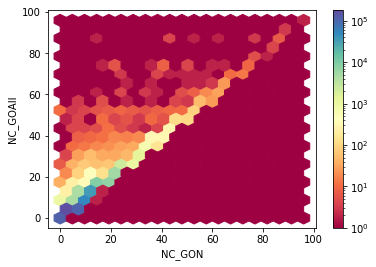

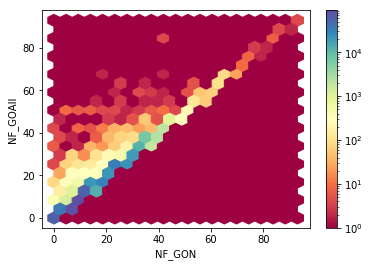

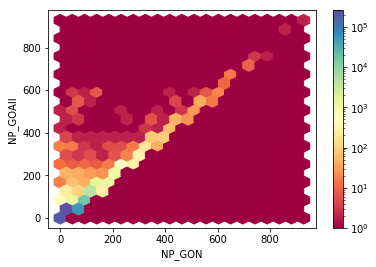

In [0]:
#(NC_GON, NF_GON, NP_GON) vs. (NC_GOAll, NF_GOAll, NP_GOAll), respectively
df.plot(kind='hexbin', x='NC_GON', y='NC_GOAll', bins='log', gridsize=20, cmap='Spectral', sharex=False); 
df.plot(kind='hexbin', x='NF_GON', y='NF_GOAll', bins='log', gridsize=20, cmap='Spectral', sharex=False); 
df.plot(kind='hexbin', x='NP_GON', y='NP_GOAll', bins='log', gridsize=20, cmap='Spectral', sharex=False); 

<Figure size 432x288 with 0 Axes>

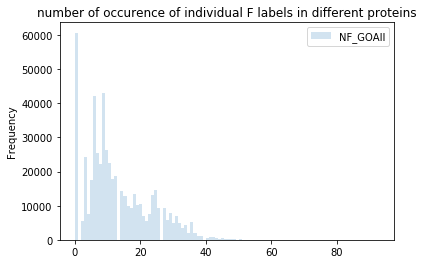

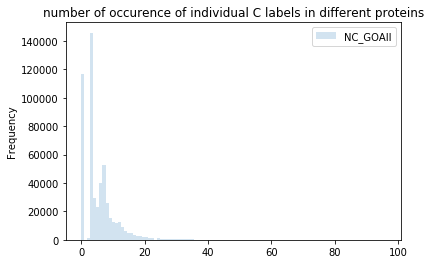

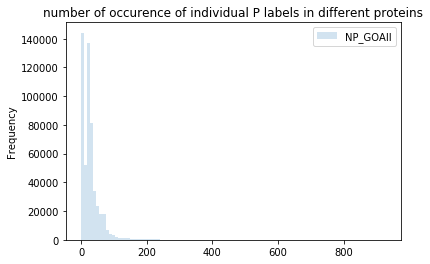

In [0]:
#number of occurence of (NC_GOAll, NF_GOAll, NP_GOAll)
plt.figure();
df.plot(kind='hist', y='NF_GOAll', bins=100, alpha=0.2);
plt.title('number of occurence of individual F labels in different proteins')
df.plot(kind='hist', y='NC_GOAll', bins=100, alpha=0.2);
plt.title('number of occurence of individual C labels in different proteins')
df.plot(kind='hist', y='NP_GOAll', bins=100, alpha=0.2);
plt.title('number of occurence of individual P labels in different proteins')
plt.show();

In [0]:
df.keys()

Index(['Unnamed: 0', 'rec_name', 'Pfam', 'protein_existance', 'seq', 'F_GO',
       'P_GO', 'C_GO', 'EC', 'Structure', 'NnonNan', 'F_GON', 'P_GON', 'C_GON',
       'dupl', 'duplFirst', 'C_GOAll', 'F_GOAll', 'P_GOAll', 'NC_GOAll',
       'NC_GON', 'NF_GOAll', 'NF_GON', 'NP_GOAll', 'NP_GON'],
      dtype='object')

### Acctually remove duplicate sequences (Assumptions: 'same sequence'='same go-terms')

In [0]:
df_noD = df.loc[df['duplFirst']==False]
df_noD.reset_index(inplace=True)

In [0]:
print('removed', df.shape[0]-df_noD.shape[0], 'duplicant sequences')

removed 83692 duplicant sequences


In [0]:
#save at this stage of cleaning (only most relevant columns)
#also save as memory built up might crash notebook
df_noD.to_csv(datasetFolder+'filteredSwissProt_noDupl_reduced.csv', columns=['seq','C_GOAll','F_GOAll','P_GOAll'])

### Memory limit might be reached soon: Better save dataset here, restart runtime and load dataset in next step!

## Remove sequences with lengths <50 and/or >650##

In [0]:
#load dataset again to save runtime memory (have to restart runtime and reimport modules/paths)
df = pd.read_csv(datasetFolder+'filteredSwissProt_noDupl_reduced.csv', usecols=['seq','C_GOAll','F_GOAll','P_GOAll'])#, sep=';')

In [0]:
df.head()

,seq,C_GOAll,F_GOAll,P_GOAll
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...,NaN,NaN,"['GO:0065007', 'GO:0050789', 'GO:0008150', 'GO..."
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...,"['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN
2,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...,"['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN
3,MDTSPYDFLKLYPWLSRGEADKGTLLDAFPGETFEQSLASDVAMRR...,NaN,"['GO:0032559', 'GO:0030554', 'GO:0032555', 'GO...",NaN
4,MKMDTDCRHWIVLASVPVLTVLAFKGEGALALAGLLVMAAVAMYRD...,"['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN


In [0]:
df.keys()

Index(['seq', 'C_GOAll', 'F_GOAll', 'P_GOAll'], dtype='object')

In [0]:
def LengthSeq(x):
    return len(x)
df['NSeq'] = df['seq'].apply(LengthSeq)

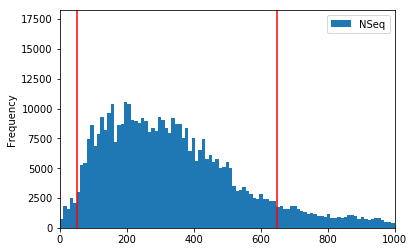

In [0]:
#distribution of length of sequences in dataset
df.plot(kind='hist', y='NSeq', bins=list(np.linspace(0,1000,100))+[np.max(df['NSeq'].values)], xlim=[0,1000]);
plt.axvline(x=50, color='red')
plt.axvline(x=650, color='red')

In [0]:
#remove sequences with length <50 or >650
previousSize = df.shape[0]
df = df.loc[((df['NSeq']>=50) & (df['NSeq']<=650))] 
df.reset_index(inplace=True)
print('an additional',previousSize-df.shape[0],'sequences where removed as their length <50 and/or >650')

an additional 62345 sequences where removed as their length <50 and/or >650


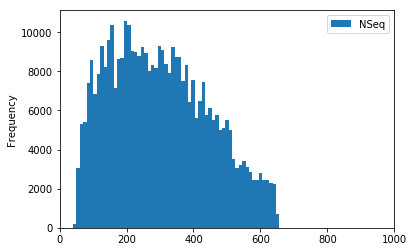

In [0]:
#distribution of length of sequences in dataset after cut
df.plot(kind='hist', y='NSeq', bins=list(np.linspace(0,1000,100)), xlim=[0,1000]);

In [0]:
# pd.eval(df_noD_SeqL50_650['C_GOAll'])
# pandas saves lists as string, have to convert str of all terms to list of terms
def split(x):
    if x is not np.nan:
        x = re.findall('(GO:[0-9]{7})',x)
    return x
df['C_GOAll'] = df['C_GOAll'].apply(split)
df['F_GOAll'] = df['F_GOAll'].apply(split)
df['P_GOAll'] = df['P_GOAll'].apply(split)

In [0]:
#occurences of labels in dataset proteins split by C,P,F terms after cut
if False: #check costs lot of memory
    cgon = np.ndarray.flatten((df['C_GOAll'].dropna().apply(lambda x: np.array(x,dtype=str))).values.flatten())
    fgon = np.ndarray.flatten((df['F_GOAll'].dropna().apply(lambda x: np.array(x,dtype=str))).values.flatten())
    pgon = np.ndarray.flatten((df['P_GOAll'].dropna().apply(lambda x: np.array(x,dtype=str))).values.flatten())
    flatten = lambda l: [item for sublist in l for item in sublist]
    cgon = flatten(cgon)
    fgon = flatten(fgon)
    pgon = flatten(pgon)
    
    plt.figure()
    ara = cgon
    values = pd.DataFrame(ara)[0].value_counts()
    bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
    pd.DataFrame(ara)[0].value_counts().hist(bins=bins,log=1,alpha=0.3)

    ara = pgon
    values = pd.DataFrame(ara)[0].value_counts()
    bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
    pd.DataFrame(ara)[0].value_counts().hist(bins=bins,log=1,alpha=0.3)

    ara = fgon
    values = pd.DataFrame(ara)[0].value_counts()
    bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
    pd.DataFrame(ara)[0].value_counts().hist(bins=bins,log=1,alpha=0.3)
    plt.title('occurence of labels in proteins after filtering')
    plt.xlabel('number of labels')
    plt.ylabel('number of occurence in proteins')
    plt.xscale('log')

In [0]:
df.head()

,index,seq,C_GOAll,F_GOAll,P_GOAll,NSeq
0,0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...,NaN,NaN,"[GO:0065007, GO:0050789, GO:0008150, GO:004390...",256
1,1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,320
2,2,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,60
3,4,MKMDTDCRHWIVLASVPVLTVLAFKGEGALALAGLLVMAAVAMYRD...,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,137
4,5,MTSVKTIAMLAMLVIVAALIYMGYRTFTSMQSKLNELESRVNAPQL...,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,70


## Convert sequence strings not lists of integers and remove non-canonical AAs


In [0]:
#convert AAs to integers with following encoding in lists of length 650, empty AAs are encoded as 0
AAdic = {"A":1,"C":2,"D":3,"E":4,"F":5,"G":6,"H":7,"I":8,"K":9,"L":10,"M":11,"N":12,"P":13,"Q":14,"R":15,"S":16,"T":17,"V":18,"W":19,"Y":20,"B":21,"X":21,"Z":21,"J":21,"U":21,"O":21}
MaxLengthSeq = 650
def convStrAAToNum(Str, AAdic, maxLength):
    aa = np.array(list(Str))#, dtype=str)
    Nlen = len(aa)
    new = np.zeros(Nlen)
    for k in AAdic.keys():
        new[np.where(aa==k)]=AAdic[k]
    new = np.array(new, dtype=int)
    return list(np.pad(new, (0,maxLength-Nlen), mode='constant'))
df['seqNum'] = df['seq'].apply(lambda x: convStrAAToNum(x, AAdic, MaxLengthSeq))

In [0]:
#check for not allowed letters and non-canonical AAs
def checkForRemStrNoCanAAs(element):
    if not all([type(x)==np.int64 for x in element]):
        #if letter not present in amino acid dic
        return -2
    elif np.max(element)>20:
        #if non-canonical AA
        return -1
    else:
        #rest
        return 1
df['seqProb'] = df['seqNum'].apply(checkForRemStrNoCanAAs)

In [0]:
#only have some sequences with non-canonical AAs
df['seqProb'].value_counts()

 1    386978
-1      1676
Name: seqProb, dtype: int64

In [0]:
#remove these sequences with non-canonical AAs
df = df.loc[df['seqProb']==1]

In [0]:
df.head()

,index,seq,C_GOAll,F_GOAll,P_GOAll,NSeq,seqNum,seqProb
0,0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...,NaN,NaN,"[GO:0065007, GO:0050789, GO:0008150, GO:004390...",256,"[11, 1, 5, 16, 1, 4, 3, 18, 10, 9, 4, 20, 3, 1...",1
1,1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,320,"[11, 16, 8, 8, 6, 1, 17, 15, 10, 14, 12, 3, 9,...",1
2,2,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,60,"[11, 12, 1, 9, 20, 3, 17, 3, 14, 6, 18, 6, 15,...",1
3,4,MKMDTDCRHWIVLASVPVLTVLAFKGEGALALAGLLVMAAVAMYRD...,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,137,"[11, 9, 11, 3, 17, 3, 2, 15, 7, 19, 8, 18, 10,...",1
4,5,MTSVKTIAMLAMLVIVAALIYMGYRTFTSMQSKLNELESRVNAPQL...,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,70,"[11, 17, 16, 18, 9, 17, 8, 1, 11, 10, 1, 11, 1...",1


In [0]:
if GOOGLE:
    drive.mount('/content/drive/', force_remount=True)
df.to_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_reduced_OnlCnc.csv', columns=['seq','seqNum','C_GOAll','F_GOAll','P_GOAll'])

Mounted at /content/drive/
